# Localization of the Regions and sub-regions

In this notebook we find different plots of the regions in which we focus the studies. We find the MLD climatology for March, over the entire North Atlantic Ocean. The datasets considered here are the ARMOR3D and ISAS, including all its versions. 
The versions of ISAS refer to the different criteria consiered to estimate the MLD, using a fixed density criteria. These are: 0.03, 0.015 and 0.046 $kg \cdot m^{-3}$.

The regions considered are: 

    1. Gulf Stream (gul)
    2. Labrador and Irminger seas (lab)
    3. North Eastern Atlantic (noe)
    4. Western Nordic Seas (nor)


We have also small sub-regions over which time series are calculated in the [Seasonal cycles](./Seasonal-cycles.ipynb) notebook. The sub-regions chosen are:
    
    1. Gulf Stream Extension
    2. South Rockall Trough
    3. Labrador Sea
    4. Irminger Sea
    5. Nordic Sea North
    6. Nordic Sea South
    

For brevity, the figure shown here corresponds only to ARMOR 3D. The Structure of this notebook is:

    1. Imported modules
    2. Dictionaries used
    3. Functions
    4. Example plot   

## 1. List of modules

In [1]:
#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

## This module disable the print of warnings in the notebook
import warnings; warnings.simplefilter('ignore')

## 2. Dictionaries

In [2]:
#########################
######### DICTIONARIES DEFINITION 
#########################

"""
Range_MLD is a dictionary that contains the limits 
of the colorbar for March and September. The format is:
<month> :
  <vmin> : lower limit
  <vmax> : upper limit
"""

Range_MLD = {
    'Mar' : {
        'vmin' : 160, 
        'vmax' : 1800},
    'Sep' : {
        'vmin' : 18, 
        'vmax' : 180},
}




"""
color_bar is a dictionary that contains the parameters 
of the colorbar for the 2D plot. The format is:
  <cmap> : colors to use in the plot
  <orrientation> : orientation of color bar in figure
  <title_cb> : title for color bar
"""

color_bar = {
    'cmap' : 'YlGnBu',
    'orientation' : 'vertical',
    'title_cbr' : 'depth [m]'
}



"""
subregions is a dictionary that has the coordinate
boundaries of the sub-regions. The format is:
<subregion> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

subregions = {
    'lab': {
        'lon' : (-55, -51),
        'lat' : (56, 59),
        'name' : 'Labrador Sea'
    },
    'irm': {
        'lon' : (-39, -35),
        'lat' : (58, 61),
        'name' : 'Irminger Sea'
    },
    'gul': {
        'lon' : (-57, -53),
        'lat' : (34, 38),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-20, -16),
        'lat' : (50, 53),
        'name' : 'North East Sea'
    },
    'nor1': {
        'lon' : (-2, 2),
        'lat' : (73, 76),
        'name' : 'Nordic Sea- Northern'
    },
    'nor2': {
        'lon' : (0, 4),
        'lat' : (68, 71),
        'name' : 'Nordic Sea- Southern'
    }   
}



"""
reg_ext is a dictionary that has the coordinate
boundaries of the main regions. The format is:
<region> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-25, 20),
        'lat' : (65, 80),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 50.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

## 3. Functions

In [3]:
def Times(data_set):
    """Times is a function that extracts the year, month and day
    from a time stamp contained in a dataset. 

    Parameters:
    ------------
    data_set : dataset
        Dataset containing, among its coordinates is time.

    Output:
    -------
    year, month, day : string time
        String with the 'year', 'month',  and 'day' values.
    """
    
    dat = data.time.values
    dat = pandas.to_datetime(dat, format='%y')
    month = dat.strftime('%b')
    year = dat.strftime('%Y')
    day =  dat.strftime('%d')
    
    return(year, month, day)


def Params(dic, var):
    if(dic['cmap']==None):
        dic['cmap'] = 'magma'
        
    if(dic['orientation']==None):
        dic['orientation'] = 'vertical'
    
    if(dic['title_cbr']==None):
        dic['title_cbr'] = str(var.long_name)
    return(dic)


def Grid(data_set):
    """Grid is a function that creates a rectangular grid using as x a longitude
    array and for y a latitude array.
        
    Parameters:
    ------------
    data_set : DataArray
        Is the dataset from which we will plot the histogram.

    Output:
    -------
    (x, y) : n-arrays
        Arrays that correspond for each (lon,lat) point
    """
    
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)



def Reg_delimitation(ax, *corner, w, h, fill=False, color=None, alpha=None):
    """Reg_delimitation is a function that draws a rectangle
    of a region over a map projection. 

    Parameters:
    ------------
    ax : axes
        Current axes object in which is drawn the rectangle.

    corner : (float, float)
        Pair of coordinates for the lower left point of the
        rectangle. corner=(x,y)

    w : float
        Number of degrees for width of rectangle.

    h : float
        Number of degrees for rectangle height. 

    fill : Boolean
        Decide if the rectangle is filled or not.

    color : string
        Color fill 

    alpha : float
        Opacity of the rectangle's filling
    """
    
    import matplotlib.patches as mpatches
    ax.add_patch(mpatches.Rectangle(xy=[*corner], width=w, height=h,
                                    fill=fill,
                                    facecolor=color,
                                    alpha=alpha,
                                    transform=ccrs.PlateCarree()
                                   )
                )
                     


    
def Map(ax, region, xtick, ytick):
    """Map is a function that helps to plot the map on a certain projection
    of a region. It always uses 50m definition of coastlines.

    Parameters:
    ------------
    ax : axes
        Current axes object in which is drawn the map.

    region : list
        Set of limit coordinates of the region to plot.
        It has the shape [lon1, lon2, lat1, lat2]

    xtick : np.array
        array containing the number and spacement of ticks 
        in x-axis.

    ytick : np.array
        Array containing the number and spacement of ticks 
        in y-axis.
    """
    
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')


    
## Need to make this a little bit more general, also in the extend. by now extends just to max
def Plot_2D(data_set, reg, *cm_levs, cmap=None, cont_line=False, nlines=None):
    """Plot_2D is a function that plots a 2D variable using a
    colormap over a spatial region. It makes use of the external 
    functions 'Grid' and 'Map'. It also makes use of the dictionary 
    'reg_ext', to get the spatial delimitations. This works only
    for DataArray type and to plot MLD. The pre-defined cmap is 
    'magma_r'.

    Parameters:
    ------------
    data_set : DataArray
        Current axes object in which is drawn the map. It can
        be a complete DataArray, or just the values for one of
        the variables.

    reg : string
        Abreviation name that identifies the region in 
        which the plot is being done. It must be defined
        inside the dictionary 'reg_ext'.

    cm_levs : tuple, integers
        It contains the parameters for the color bar. The 
        order is: minimum, maximum, #of levels

    cmap : String
        Name of the color map to use. Default is 'magma_r'

    cont_line : Boolean
        If True we allow to plot a second contour plot of SSH. 
        On top of the MLD heat map.
        If False, this function plots a heat map of the variable 
        set by parameter 'data_set'.

    nlines : integers
        Is the number of lines to plot the contour plot. It is 
        optional, and is necessary when cont_line=True.

    Output:
    ------------
    ax : axes
    """
    
    # Shaping the plot
    x_n, y_n = Grid(data_set)
    projection = ccrs.PlateCarree(360)
    
    # Getting the delimitations and ticks
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtick = np.linspace(lon1, lon2, num=6)
    ytick = np.linspace(lat1, lat2, num=4)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    # If we want to plot MLD and SSH, or other thing, without SSH countours
    if cont_line:
        variable = data_set.mlotst
    else:
        variable = data_set
        
    if not cmap:
        cmap = 'plasma_r'

    # Start of the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtick, ytick)
    
    # Here plot the variable using a heat map, defining also color bar
    contr1 = ax.contourf(x_n, y_n, variable, 
                         levels=np.linspace(cm_levs[0], cm_levs[1], cm_levs[2]),
                         cmap=cmap, extend='max')
    
    cbar = fig.colorbar(contr1, ax=ax, shrink=0.85, orientation='vertical', 
                        label='MLD [m]', extend='both')  
    
    # Here adding an extra layer of SSH at surface using countour lines
    if cont_line:
        contr2 = ax.contour(x_n, y_n, data_set.zo[0], nlines, linewidths=0.5, colors='k')
    
    # Saving the figure
    ##if save:
    ##    fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))

    return(ax)


def Masking(data_set, cond):
    """Maskin is a function that makes a mask of an array depending on the 
    entering condition. The condition is evaluated over finite numbers.
    At the final, the mask is appended in the original DataArray as a 
    new coordinate.

    Parameters:
    ------------
    data_set : DataArray
        Is the array we want to make the mask of.

    cond : array
        Codition to meet. 


    Output:
    -------
    data_set : Numpy Arrray
        Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


## Opening datasets - Only ARMOR 3D in this notebook
dir_1 = '../../../New_ARMOR/'
dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'


fl_n1 = 'NARMOR_*.nc'
c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')

In [5]:
## These lines assign the time stamps for each time step
## of the ARMOR 3D dataset. Note that 2018 is not complete.
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

In [6]:
## Taking just MLD from the datasets
mld_a = c_armor1.mlotst

## Climatology
month_a = mld_a.groupby('time.month').mean('time')

In [7]:
## Making lists of the names and dataarrays to plot
## The names are for the title of the figure

data_sets = [month_a.sel(month=3)]
#data_sets = [month_a.sel(month=3).where(c_armor15.mask==1), month_i.sel(depth=1,month=3),
#             month_i2.sel(depth=1, month=3), month_i3.sel(depth=1, month=3),
#             month_i4.sel(depth=1, month=3)]

names = ['ARMOR-3D']#, 'ISAS-original', 'ISAS-003',
#         'ISAS-0015', 'ISAS-0046']

## Chosing the limits of the colorbar
month = 'Mar'
vmin = Range_MLD[month]['vmin']
vmax = Range_MLD[month]['vmax']

In [8]:
## Left-down point of the regions
# c_n :: for the small regions
# ce_n :: for the large regions

c_1 = (-57, 34) # Gulf Stream
ce_1 = (-75, 30)

c_2 = (-39, 58) # Irminger
c_3 = (-55, 56) # Labrador
ce_23 = (-60, 50)

c_4 = (-20, 50) # Northe East
ce_4 = (-30, 45)

c_51 = (-2, 73)
c_52 = (0, 68)
ce_5 = (-25, 65)  # Nordic Seas

In [9]:
title1 = 'Mixed layer depth [m]\nNorth Atlantic Ocean'
title2 = ' dataset'

## ARMOR-3D

<IPython.core.display.Javascript object>


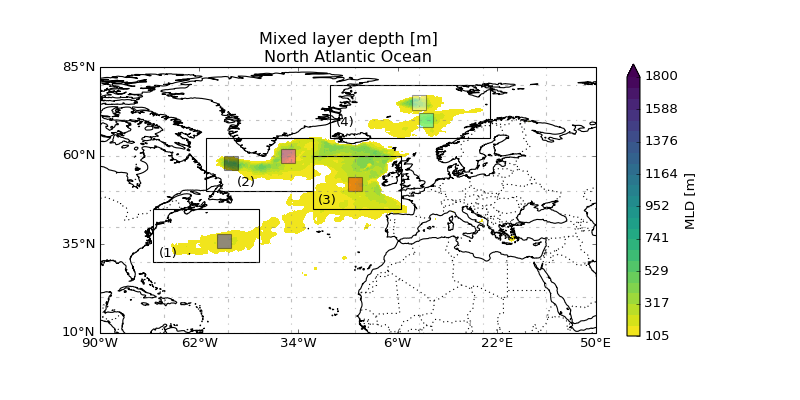

In [10]:
%matplotlib notebook

name = 'Gulf_stream_ARMOR_dist2'

plt.close()

cm_levs = (105., vmax, 25)
ax = Plot_2D(data_sets[0], 'noa', *cm_levs, cmap='viridis_r',cont_line=False, nlines=None)

## Plot a circle in the (lon,lat), filled with the color stated
#ax.plot(points['gul']['lon'], points['gul']['lat'], color='blue', linewidth=2, marker='o',
#         transform=ccrs.Geodetic())

## Gulf Stream- sub-region & region
Reg_delimitation(ax, *c_1, w=4, h=4, fill=True, color='blue', alpha=0.4)
Reg_delimitation(ax, *ce_1, w=30, h=15, fill=False)
plt.text(ce_1[0]+1.5, ce_1[1]+1.5, s='(1)', size=12)    # Gulf Stream


## Labrador and Irminger Seas- sub-regions & region
Reg_delimitation(ax, *c_3, w=4, h=4, fill=True, color='k', alpha=0.4)
Reg_delimitation(ax, *c_2, w=4, h=4, fill=True, color='magenta', alpha=0.4)
Reg_delimitation(ax, *ce_23, w=30, h=15, fill=False)
plt.text(ce_23[0]+8.5, ce_23[1]+1.5, s='(2)', size=12)    # Labrador


## Northe East Atlantic- sub-region & region
Reg_delimitation(ax, *c_4, w=4, h=4, fill=True, color='red', alpha=0.4)
Reg_delimitation(ax, *ce_4, w=25, h=15, fill=False)
plt.text(ce_4[0]+1.5, ce_4[1]+1.5, s='(3)', size=12)    # North East


## Nordic Seas- sub-regions & region
Reg_delimitation(ax, *c_51, w=4, h=4, fill=True, color='w', alpha=0.4)
Reg_delimitation(ax, *c_52, w=4, h=4, fill=True, color='cyan', alpha=0.4)
Reg_delimitation(ax, *ce_5, w=45, h=15, fill=False)
plt.text(ce_5[0]+1.5, ce_5[1]+3.5, s='(4)', size=12)    # Nordic Seas

ax.set_title(title1)
#plt.savefig(dir_o + name, bbox_inches='tight')
plt.show()
